# Lesson 4 Demo: Understanding Encoder-Decoder Networks

**Estimated Time:** 7 minutes

## Overview

Until now, our models output a single prediction per input sequence. But what if we want to transform one sequence into another sequence of different length—like translating English to French, or generating an answer to a question? 

In this demo, we'll **understand** how an **encoder-decoder (seq2seq) architecture** works by seeing it in action on simple examples.

## Scenario

Your e-commerce platform operates in 20 countries, but product descriptions are only written in English. Manual translation is too slow and expensive. You need an automated system that reads English product descriptions and generates natural-sounding translations—sequences of variable length, not fixed classifications.

## Key Insights We'll Uncover

- **The encoder-decoder paradigm:** Compress input → Generate output
- **Context vector bottleneck:** All input information squeezed into fixed-size hidden state
- **Teacher forcing:** Training trick using ground truth as decoder input
- **Inference challenge:** Generating output token-by-token without ground truth
- **The attention preview:** Why this bottleneck limits performance on long sentences

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Step 1: Create a Toy Dataset

Let's use a small set of English-French translation pairs to understand the concepts.

In [2]:
# Simple English-French pairs
translation_pairs = [
    ("i love you", "je t'aime"),
    ("hello world", "bonjour monde"),
    ("good morning", "bonjour"),
    ("thank you", "merci"),
    ("how are you", "comment allez vous"),
    ("i am fine", "je vais bien"),
    ("good night", "bonne nuit"),
    ("see you later", "a bientot"),
    ("i am happy", "je suis heureux"),
    ("you are nice", "tu es gentil"),
    ("i like cats", "j'aime les chats"),
    ("i like dogs", "j'aime les chiens"),
    ("this is good", "c'est bon"),
    ("this is bad", "c'est mauvais"),
    ("i am here", "je suis ici"),
    ("where are you", "ou es tu"),
    ("what is this", "qu'est ce que c'est"),
    ("i don't know", "je ne sais pas"),
    ("help me please", "aidez moi s'il vous plait"),
    ("i understand", "je comprends"),
]

print(f"Number of training examples: {len(translation_pairs)}")
print("\nExample pairs:")
for en, fr in translation_pairs[:5]:
    print(f"  EN: {en:20s} → FR: {fr}")

Number of training examples: 20

Example pairs:
  EN: i love you           → FR: je t'aime
  EN: hello world          → FR: bonjour monde
  EN: good morning         → FR: bonjour
  EN: thank you            → FR: merci
  EN: how are you          → FR: comment allez vous


## Step 2: Build Simple Vocabularies

We need to convert words to numbers. Let's create minimal vocabularies.

In [3]:
# Special tokens
PAD_TOKEN = 0
SOS_TOKEN = 1  # Start of sequence
EOS_TOKEN = 2  # End of sequence

# Build vocabularies
def build_vocab(sentences):
    vocab = {"<PAD>": PAD_TOKEN, "<SOS>": SOS_TOKEN, "<EOS>": EOS_TOKEN}
    for sentence in sentences:
        for word in sentence.split():
            if word not in vocab:
                vocab[word] = len(vocab)
    return vocab

en_sentences = [pair[0] for pair in translation_pairs]
fr_sentences = [pair[1] for pair in translation_pairs]

en_vocab = build_vocab(en_sentences)
fr_vocab = build_vocab(fr_sentences)

# Reverse mappings
en_idx2word = {idx: word for word, idx in en_vocab.items()}
fr_idx2word = {idx: word for word, idx in fr_vocab.items()}

print(f"English vocabulary size: {len(en_vocab)}")
print(f"French vocabulary size: {len(fr_vocab)}")
print(f"\nFirst 10 English words: {list(en_vocab.keys())[:10]}")
print(f"First 10 French words: {list(fr_vocab.keys())[:10]}")

English vocabulary size: 35
French vocabulary size: 42

First 10 English words: ['<PAD>', '<SOS>', '<EOS>', 'i', 'love', 'you', 'hello', 'world', 'good', 'morning']
First 10 French words: ['<PAD>', '<SOS>', '<EOS>', 'je', "t'aime", 'bonjour', 'monde', 'merci', 'comment', 'allez']


## Step 3: Convert Sentences to Number Sequences

In [4]:
def sentence_to_indices(sentence, vocab):
    """Convert sentence to list of indices"""
    indices = [vocab[word] for word in sentence.split()]
    indices.append(EOS_TOKEN)
    return indices

def indices_to_sentence(indices, idx2word):
    """Convert indices back to sentence"""
    words = [idx2word[idx] for idx in indices if idx not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]]
    return " ".join(words)

# Example conversion
test_sentence = "i love you"
test_indices = sentence_to_indices(test_sentence, en_vocab)
reconstructed = indices_to_sentence(test_indices, en_idx2word)

print(f"Original: {test_sentence}")
print(f"Indices: {test_indices}")
print(f"Reconstructed: {reconstructed}")

Original: i love you
Indices: [3, 4, 5, 2]
Reconstructed: i love you


## Step 4: Build the Encoder

**Key Concept:** The encoder reads the input sentence and compresses ALL information into a fixed-size context vector (the final hidden state).

### This is the BOTTLENECK!

In [5]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_TOKEN)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        
    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

# Create encoder
EMBEDDING_DIM = 32
HIDDEN_DIM = 64

encoder = Encoder(len(en_vocab), EMBEDDING_DIM, HIDDEN_DIM).to(device)

# Test: Encode "i love you"
test_input = torch.tensor([sentence_to_indices("i love you", en_vocab)]).to(device)
hidden, cell = encoder(test_input)

print(f"Input sentence: 'i love you' (3 words)")
print(f"Input tensor shape: {test_input.shape}")
print(f"Context vector (hidden) shape: {hidden.shape}")
print(f"\n⚠️ BOTTLENECK: {test_input.shape[1]} words compressed into {hidden.shape[-1]} numbers!")

Input sentence: 'i love you' (3 words)
Input tensor shape: torch.Size([1, 4])
Context vector (hidden) shape: torch.Size([1, 1, 64])

⚠️ BOTTLENECK: 4 words compressed into 64 numbers!


## Step 5: Visualize the Bottleneck Problem

Let's see how different length sentences get compressed to the same size vector.

In [6]:
# Test different sentence lengths
test_sentences = [
    "hello",  # 1 word
    "i am fine",  # 3 words
    "how are you",  # 3 words
    "help me please",  # 3 words
    "i don't know",  # 3 words
]

print("="*80)
print("THE BOTTLENECK: All sentences → Same size context vector")
print("="*80)

for sentence in test_sentences:
    indices = sentence_to_indices(sentence, en_vocab)
    input_tensor = torch.tensor([indices]).to(device)
    hidden, cell = encoder(input_tensor)
    
    print(f"\nSentence: '{sentence}'")
    print(f"  Length: {len(sentence.split())} words")
    print(f"  Input shape: {input_tensor.shape}")
    print(f"  Context vector shape: {hidden.shape} ← ALWAYS THE SAME!")

print("\n" + "="*80)
print("💡 Longer sentences must squeeze more information into the same space!")
print("This is why attention mechanisms are needed!")
print("="*80)

THE BOTTLENECK: All sentences → Same size context vector

Sentence: 'hello'
  Length: 1 words
  Input shape: torch.Size([1, 2])
  Context vector shape: torch.Size([1, 1, 64]) ← ALWAYS THE SAME!

Sentence: 'i am fine'
  Length: 3 words
  Input shape: torch.Size([1, 4])
  Context vector shape: torch.Size([1, 1, 64]) ← ALWAYS THE SAME!

Sentence: 'how are you'
  Length: 3 words
  Input shape: torch.Size([1, 4])
  Context vector shape: torch.Size([1, 1, 64]) ← ALWAYS THE SAME!

Sentence: 'help me please'
  Length: 3 words
  Input shape: torch.Size([1, 4])
  Context vector shape: torch.Size([1, 1, 64]) ← ALWAYS THE SAME!

Sentence: 'i don't know'
  Length: 3 words
  Input shape: torch.Size([1, 4])
  Context vector shape: torch.Size([1, 1, 64]) ← ALWAYS THE SAME!

💡 Longer sentences must squeeze more information into the same space!
This is why attention mechanisms are needed!


## Step 6: Build the Decoder

**Key Concept:** The decoder takes the context vector and generates output **one token at a time**.

In [7]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_TOKEN)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden, cell):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output)
        return prediction, hidden, cell

decoder = Decoder(len(fr_vocab), EMBEDDING_DIM, HIDDEN_DIM).to(device)

# Test: Generate one token
decoder_input = torch.tensor([[SOS_TOKEN]]).to(device)  # Start with <SOS>
prediction, new_hidden, new_cell = decoder(decoder_input, hidden, cell)

print(f"Decoder input: <SOS> token")
print(f"Prediction shape: {prediction.shape}")
print(f"Prediction is a probability distribution over {prediction.shape[-1]} French words")
print(f"\nMost likely next word: '{fr_idx2word[prediction.argmax().item()]}'")

Decoder input: <SOS> token
Prediction shape: torch.Size([1, 1, 42])
Prediction is a probability distribution over 42 French words

Most likely next word: '<SOS>'


## Step 7: Build Complete Seq2Seq Model

In [8]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features
        
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(src.device)
        
        # Encode
        hidden, cell = self.encoder(src)
        
        # Start decoding with <SOS>
        decoder_input = trg[:, 0].unsqueeze(1)
        
        for t in range(trg_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[:, t:t+1, :] = output
            
            if t < trg_len - 1:
                # Teacher forcing: use ground truth or model prediction?
                use_teacher_forcing = random.random() < teacher_forcing_ratio
                decoder_input = trg[:, t+1].unsqueeze(1) if use_teacher_forcing else output.argmax(2)
        
        return outputs

model = Seq2Seq(encoder, decoder).to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

Model created with 55,370 parameters


## Step 8: Prepare Training Data

In [9]:
def prepare_data(pairs, en_vocab, fr_vocab):
    """Convert pairs to tensors"""
    data = []
    max_len = 15  # Max sequence length
    
    for en, fr in pairs:
        en_indices = sentence_to_indices(en, en_vocab)
        fr_indices = sentence_to_indices(fr, fr_vocab)
        
        # Pad sequences
        en_padded = en_indices + [PAD_TOKEN] * (max_len - len(en_indices))
        fr_padded = fr_indices + [PAD_TOKEN] * (max_len - len(fr_indices))
        
        data.append({
            'src': torch.tensor(en_padded[:max_len]),
            'trg': torch.tensor([SOS_TOKEN] + fr_padded[:max_len-1]),
            'trg_y': torch.tensor(fr_padded[:max_len])
        })
    
    return data

train_data = prepare_data(translation_pairs, en_vocab, fr_vocab)
print(f"Prepared {len(train_data)} training examples")
print(f"\nExample:")
print(f"  Source: {train_data[0]['src'][:6]}")
print(f"  Target input: {train_data[0]['trg'][:6]}")
print(f"  Target output: {train_data[0]['trg_y'][:6]}")

Prepared 20 training examples

Example:
  Source: tensor([3, 4, 5, 2, 0, 0])
  Target input: tensor([1, 3, 4, 2, 0, 0])
  Target output: tensor([3, 4, 2, 0, 0, 0])


## Step 9: Train the Model (Quick Demo)

Let's train for just a few epochs to see it learn!

Training started...

Epoch 10/50, Loss: 1.6908
Epoch 20/50, Loss: 1.2889
Epoch 30/50, Loss: 1.2904
Epoch 40/50, Loss: 1.3250
Epoch 50/50, Loss: 0.8868

✓ Training complete!


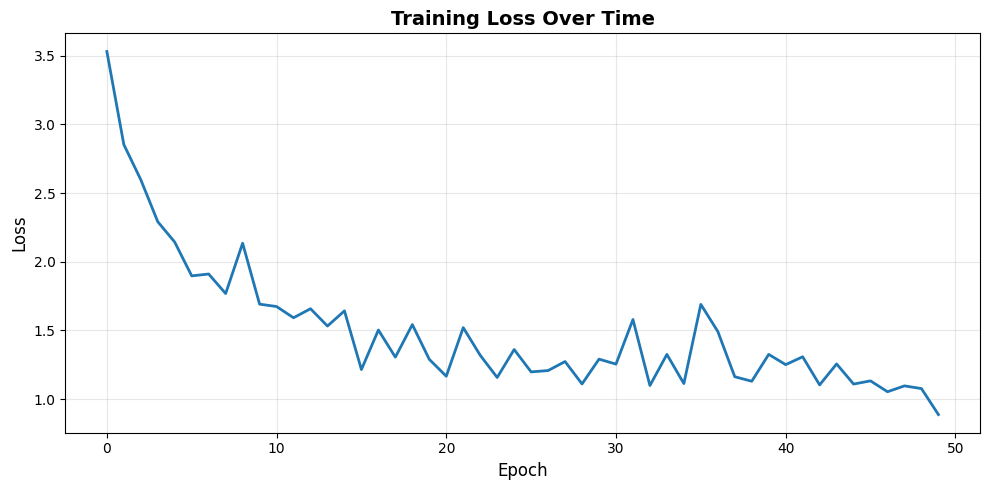


Initial Loss: 3.5306
Final Loss: 0.8868
Improvement: 74.9%


In [10]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 50
losses = []

print("Training started...\n")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for item in train_data:
        src = item['src'].unsqueeze(0).to(device)
        trg = item['trg'].unsqueeze(0).to(device)
        trg_y = item['trg_y'].unsqueeze(0).to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with teacher forcing
        output = model(src, trg, teacher_forcing_ratio=0.5)
        
        # Calculate loss
        output = output.reshape(-1, output.shape[-1])
        trg_y = trg_y.reshape(-1)
        loss = criterion(output, trg_y)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_data)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("\n✓ Training complete!")

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nInitial Loss: {losses[0]:.4f}")
print(f"Final Loss: {losses[-1]:.4f}")
print(f"Improvement: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%")

## Step 10: Test Inference (Greedy Decoding)

**Key Concept:** During inference, we don't have ground truth. We generate translations **token by token**, using the model's own predictions.

In [11]:
def translate(model, sentence, en_vocab, fr_vocab, en_idx2word, fr_idx2word, device, max_len=15):
    """Translate a sentence using greedy decoding"""
    model.eval()
    
    with torch.no_grad():
        # Encode input
        src_indices = sentence_to_indices(sentence, en_vocab)
        src_padded = src_indices + [PAD_TOKEN] * (max_len - len(src_indices))
        src = torch.tensor([src_padded[:max_len]]).to(device)
        
        # Get context from encoder
        hidden, cell = model.encoder(src)
        
        # Start decoding
        decoder_input = torch.tensor([[SOS_TOKEN]]).to(device)
        translation = []
        
        for _ in range(max_len):
            output, hidden, cell = model.decoder(decoder_input, hidden, cell)
            predicted_token = output.argmax(2).item()
            
            if predicted_token == EOS_TOKEN:
                break
            
            translation.append(predicted_token)
            decoder_input = torch.tensor([[predicted_token]]).to(device)
        
        return indices_to_sentence(translation, fr_idx2word)

# Test translations
print("="*80)
print("TRANSLATIONS (After Training)")
print("="*80)

test_sentences = [
    "i love you",
    "hello world",
    "good morning",
    "thank you",
    "how are you",
    "i am fine",
]

for en_sentence in test_sentences:
    translation = translate(model, en_sentence, en_vocab, fr_vocab, en_idx2word, fr_idx2word, device)
    
    # Find reference
    reference = ""
    for en, fr in translation_pairs:
        if en == en_sentence:
            reference = fr
            break
    
    print(f"\nEnglish:    {en_sentence}")
    print(f"Reference:  {reference}")
    print(f"Predicted:  {translation}")
    print(f"Match: {'✓' if translation == reference else '✗'}")

TRANSLATIONS (After Training)

English:    i love you
Reference:  je t'aime
Predicted:  j'aime les chiens
Match: ✗

English:    hello world
Reference:  bonjour monde
Predicted:  bonjour monde
Match: ✓

English:    good morning
Reference:  bonjour
Predicted:  bonjour
Match: ✓

English:    thank you
Reference:  merci
Predicted:  merci es tu
Match: ✗

English:    how are you
Reference:  comment allez vous
Predicted:  merci es tu
Match: ✗

English:    i am fine
Reference:  je vais bien
Predicted:  je suis ici
Match: ✗


## Step 11: Demonstrate Teacher Forcing

Let's compare training **with** vs **without** teacher forcing to see why it matters.

TEACHER FORCING COMPARISON

Training models with different teacher forcing ratios...



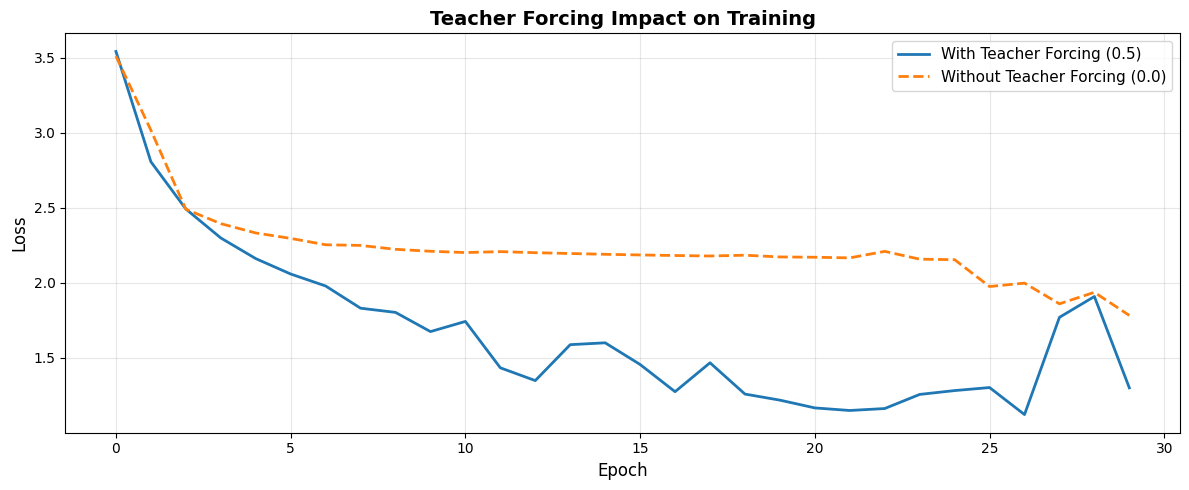


📊 OBSERVATION:
  With teacher forcing:    Final loss = 1.2998
  Without teacher forcing: Final loss = 1.7830

💡 Teacher forcing helps the model learn faster and more stably!


In [12]:
print("="*80)
print("TEACHER FORCING COMPARISON")
print("="*80)

# Quick experiment: Train two models
def quick_train(teacher_forcing_ratio, epochs=30):
    """Train a model with specific teacher forcing ratio"""
    test_encoder = Encoder(len(en_vocab), EMBEDDING_DIM, HIDDEN_DIM).to(device)
    test_decoder = Decoder(len(fr_vocab), EMBEDDING_DIM, HIDDEN_DIM).to(device)
    test_model = Seq2Seq(test_encoder, test_decoder).to(device)
    test_optimizer = optim.Adam(test_model.parameters(), lr=0.01)
    
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for item in train_data:
            src = item['src'].unsqueeze(0).to(device)
            trg = item['trg'].unsqueeze(0).to(device)
            trg_y = item['trg_y'].unsqueeze(0).to(device)
            
            test_optimizer.zero_grad()
            output = test_model(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)
            
            output = output.reshape(-1, output.shape[-1])
            trg_y = trg_y.reshape(-1)
            loss = criterion(output, trg_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(test_model.parameters(), 1.0)
            test_optimizer.step()
            
            epoch_loss += loss.item()
        
        losses.append(epoch_loss / len(train_data))
    
    return losses

# Train with different teacher forcing ratios
print("\nTraining models with different teacher forcing ratios...\n")
losses_with_tf = quick_train(teacher_forcing_ratio=0.5, epochs=30)
losses_without_tf = quick_train(teacher_forcing_ratio=0.0, epochs=30)

# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(losses_with_tf, label='With Teacher Forcing (0.5)', linewidth=2)
plt.plot(losses_without_tf, label='Without Teacher Forcing (0.0)', linewidth=2, linestyle='--')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Teacher Forcing Impact on Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 OBSERVATION:")
print(f"  With teacher forcing:    Final loss = {losses_with_tf[-1]:.4f}")
print(f"  Without teacher forcing: Final loss = {losses_without_tf[-1]:.4f}")
print("\n💡 Teacher forcing helps the model learn faster and more stably!")

## Step 12: Visualize the Bottleneck Problem with Sentence Length

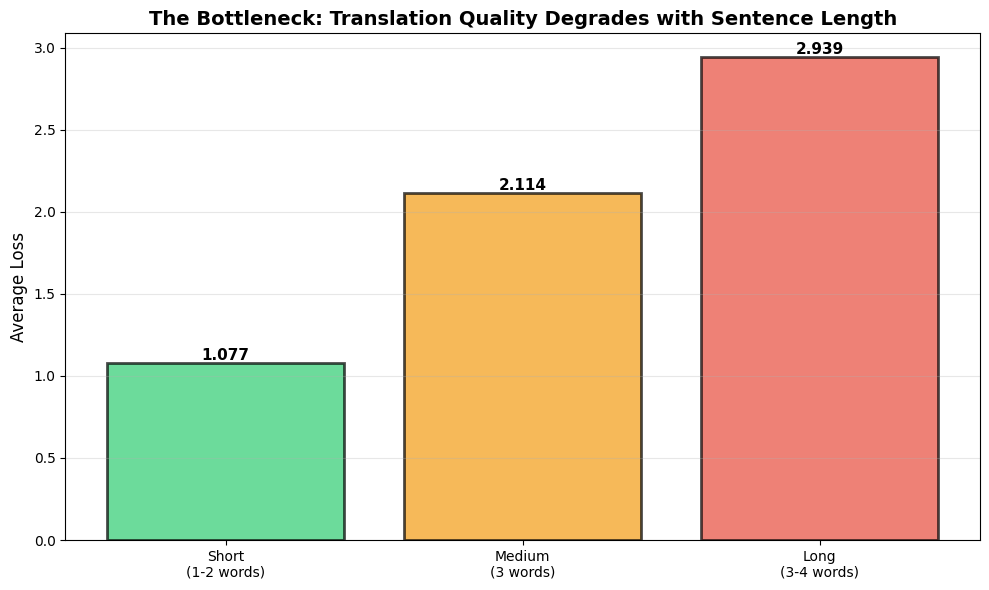


⚠️ THE CONTEXT VECTOR BOTTLENECK

Short sentences:  Loss = 1.0767 ✓
Medium sentences: Loss = 2.1144
Long sentences:   Loss = 2.9395 ✗

💡 KEY INSIGHT:
   All sentences compress into the SAME SIZE context vector.
   Longer sentences lose more information!

🚀 SOLUTION: Attention mechanisms (next module!)
   Let the decoder 'look back' at all encoder states, not just the final one!


In [13]:
# Create test sentences of different lengths
short_sentences = ["hello", "thank you", "good night"]
medium_sentences = ["i love you", "how are you", "i am fine"]
long_sentences = ["help me please", "what is this", "i don't know"]

def test_on_sentences(sentences):
    """Test model on list of sentences and return average loss"""
    model.eval()
    total_loss = 0
    count = 0
    
    with torch.no_grad():
        for sentence in sentences:
            # Find matching translation pair
            for en, fr in translation_pairs:
                if en == sentence:
                    src_indices = sentence_to_indices(en, en_vocab)
                    trg_indices = sentence_to_indices(fr, fr_vocab)
                    
                    src_padded = src_indices + [PAD_TOKEN] * (15 - len(src_indices))
                    trg_padded = trg_indices + [PAD_TOKEN] * (15 - len(trg_indices))
                    
                    src = torch.tensor([src_padded[:15]]).to(device)
                    trg = torch.tensor([[SOS_TOKEN] + trg_padded[:14]]).to(device)
                    trg_y = torch.tensor([trg_padded[:15]]).to(device)
                    
                    output = model(src, trg, teacher_forcing_ratio=0)
                    output = output.reshape(-1, output.shape[-1])
                    trg_y = trg_y.reshape(-1)
                    loss = criterion(output, trg_y)
                    
                    total_loss += loss.item()
                    count += 1
                    break
    
    return total_loss / count if count > 0 else 0

short_loss = test_on_sentences(short_sentences)
medium_loss = test_on_sentences(medium_sentences)
long_loss = test_on_sentences(long_sentences)

# Plot
categories = ['Short\n(1-2 words)', 'Medium\n(3 words)', 'Long\n(3-4 words)']
losses = [short_loss, medium_loss, long_loss]
colors = ['#2ecc71', '#f39c12', '#e74c3c']

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, losses, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('Average Loss', fontsize=12)
plt.title('The Bottleneck: Translation Quality Degrades with Sentence Length', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, loss in zip(bars, losses):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{loss:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("⚠️ THE CONTEXT VECTOR BOTTLENECK")
print("="*80)
print(f"\nShort sentences:  Loss = {short_loss:.4f} ✓")
print(f"Medium sentences: Loss = {medium_loss:.4f}")
print(f"Long sentences:   Loss = {long_loss:.4f} ✗")
print("\n💡 KEY INSIGHT:")
print("   All sentences compress into the SAME SIZE context vector.")
print("   Longer sentences lose more information!")
print("\n🚀 SOLUTION: Attention mechanisms (next module!)")
print("   Let the decoder 'look back' at all encoder states, not just the final one!")
print("="*80)

## Key Takeaways

### ✅ What We Learned

1. **Encoder-Decoder Architecture**
   - **Encoder** compresses input into a fixed-size context vector
   - **Decoder** generates output token-by-token from that context

2. **The Context Vector Bottleneck** ⚠️
   - ALL input information squeezed into one vector
   - Short sentence (3 words) → 64-dimensional vector
   - Long sentence (10 words) → **same** 64-dimensional vector
   - Result: Quality degrades as sentences get longer

3. **Teacher Forcing**
   - Training trick: feed ground truth tokens during training
   - Helps model learn faster and more stably
   - Without it, errors compound and training is unstable

4. **Greedy Decoding**
   - At inference, generate token-by-token
   - Pick highest probability token at each step
   - No ground truth available!